In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler,LabelEncoder,StandardScaler

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()


,founder_id,founder_age,founder_gender,years_with_startup,founder_role,monthly_revenue_generated,work_life_balance_rating,venture_satisfaction,startup_performance_rating,funding_rounds_led,...,num_dependents,startup_stage,team_size_category,years_since_founding,remote_operations,leadership_scope,innovation_support,startup_reputation,founder_visibility,retention_status
0,8410,31,Male,19,Education,5390.0,Excellent,Medium,Average,2,...,0.0,Mid,Medium,89.0,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534.0,Poor,High,Low,3,...,3.0,Mid,Medium,21.0,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159.0,Good,High,Low,0,...,3.0,Mid,Medium,74.0,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989.0,Good,High,High,1,...,2.0,Mid,Small,50.0,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821.0,NaN,NaN,Average,0,...,0.0,Senior,Medium,68.0,No,No,No,Fair,Medium,Stayed


In [ ]:
train.isnull().sum()


founder_id                        0
founder_age                       0
founder_gender                    0
years_with_startup                0
founder_role                      0
monthly_revenue_generated      1800
work_life_balance_rating      10144
venture_satisfaction           7164
startup_performance_rating        0
funding_rounds_led                0
working_overtime                  0
distance_from_investor_hub        0
education_background              0
personal_status                   0
num_dependents                 4780
startup_stage                     0
team_size_category             2992
years_since_founding           4184
remote_operations                 0
leadership_scope                  0
innovation_support                0
startup_reputation                0
founder_visibility                0
retention_status                  0
dtype: int64

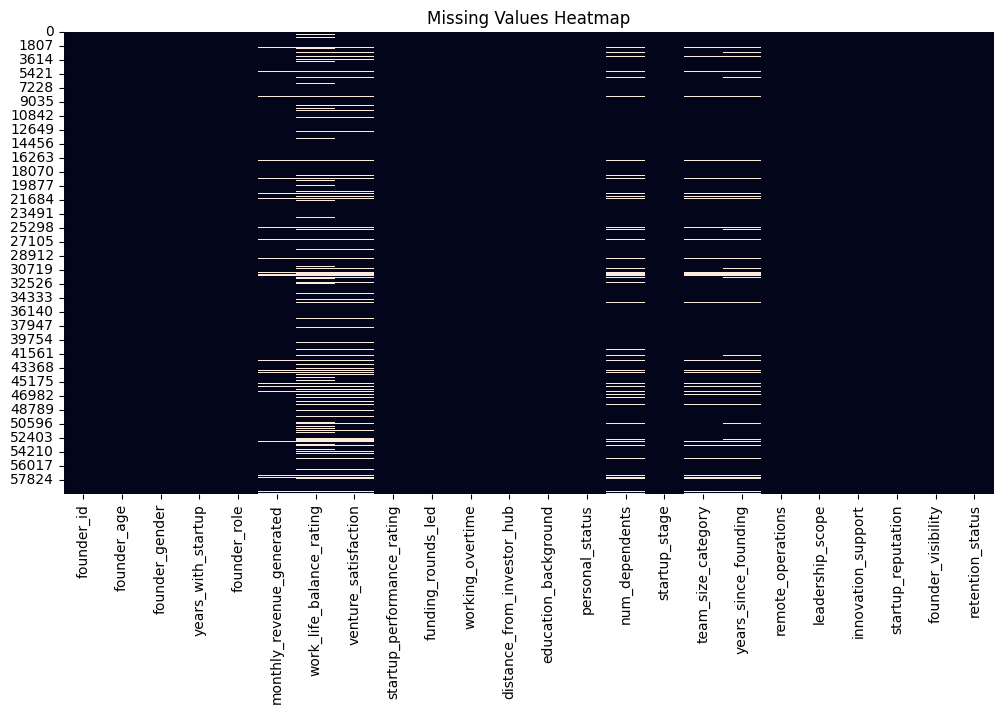

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


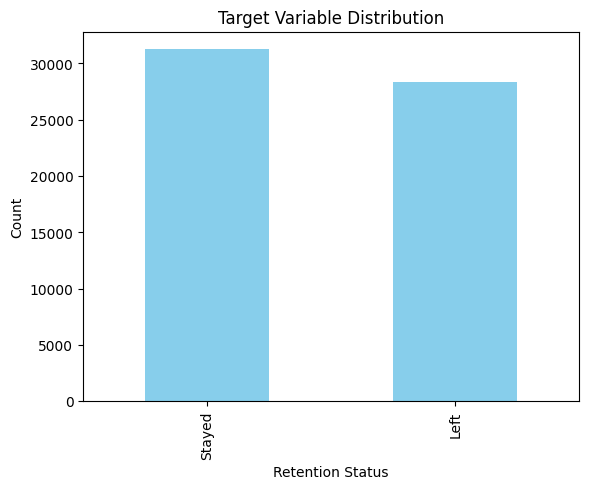

In [ ]:
train['retention_status'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Target Variable Distribution")
plt.xlabel("Retention Status")
plt.ylabel("Count")
plt.show()


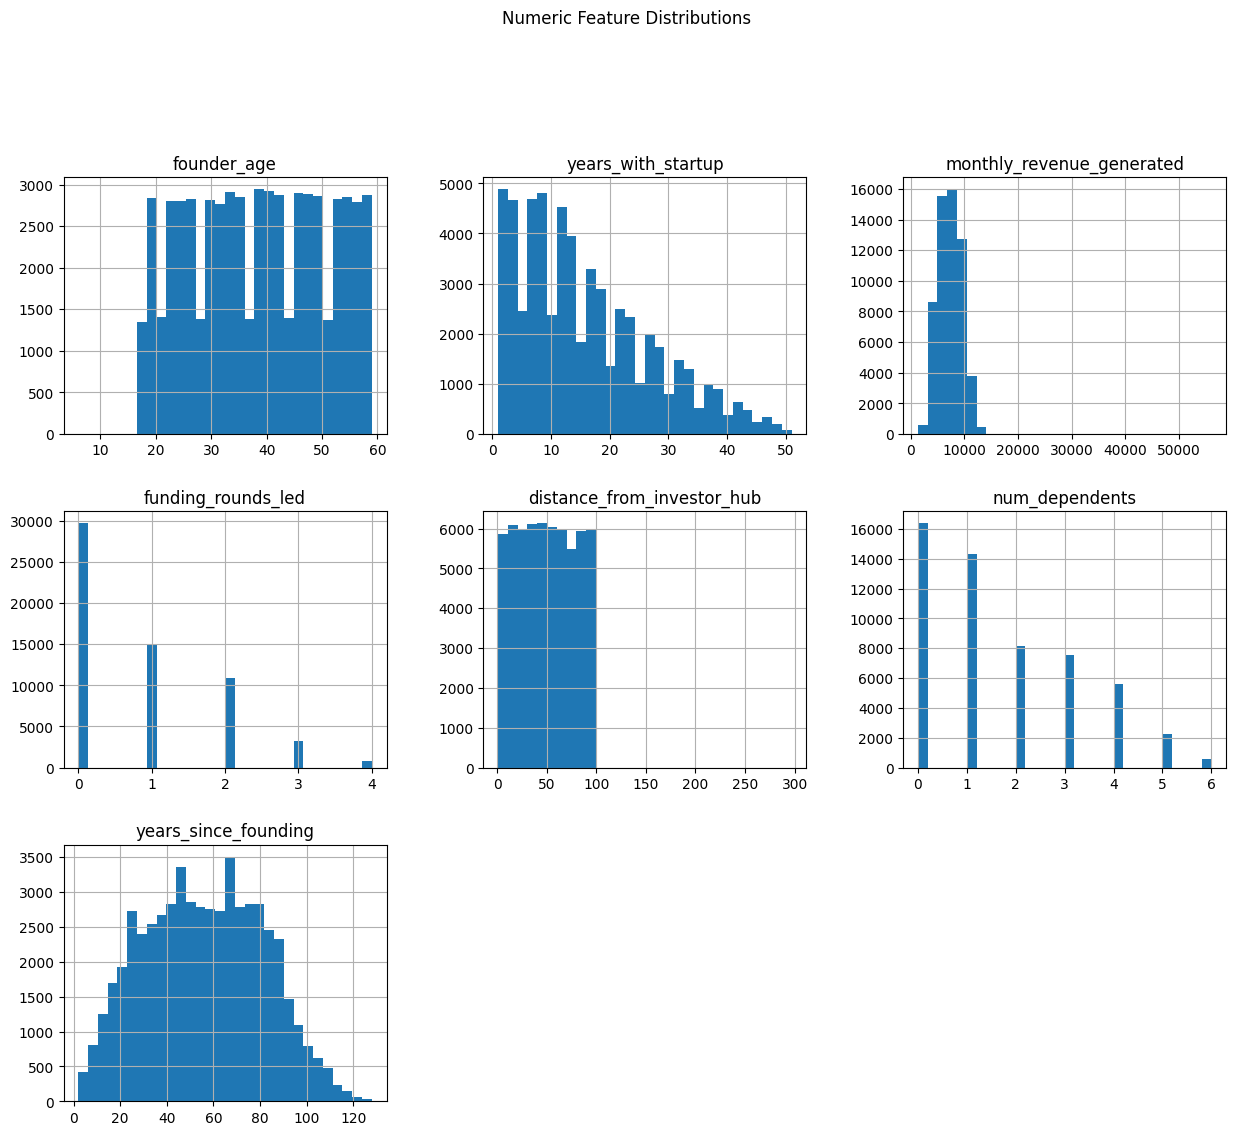

In [ ]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('founder_id')

train[numeric_cols].hist(figsize=(15,12), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()


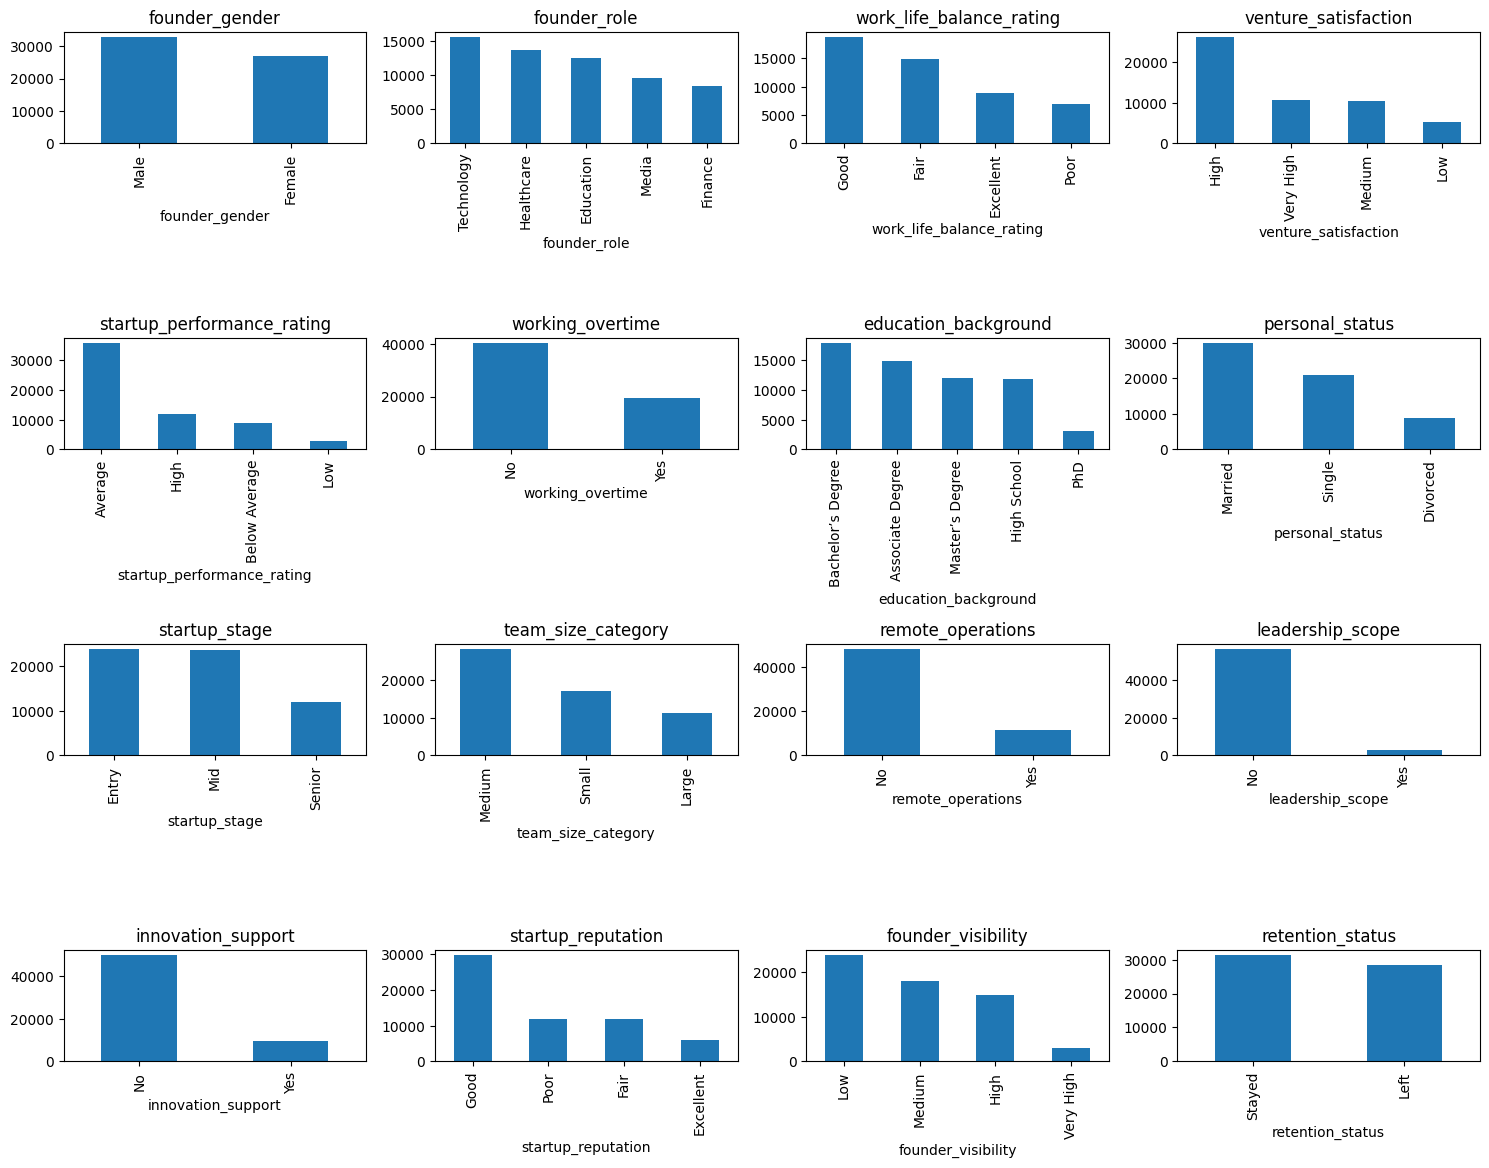

In [ ]:
categorical_cols = train.select_dtypes(include=['object','category']).columns
plt.figure(figsize=(15,20))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(7, 4, i)
    train[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.tight_layout()


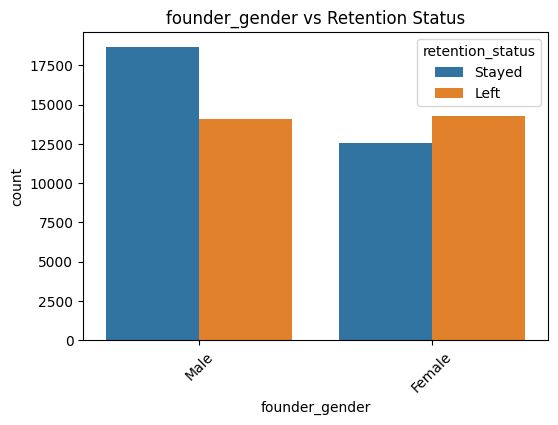

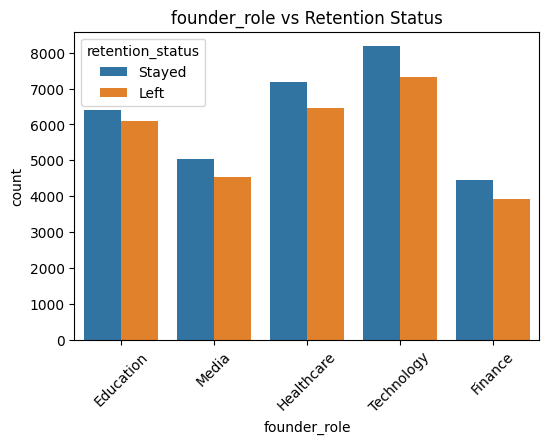

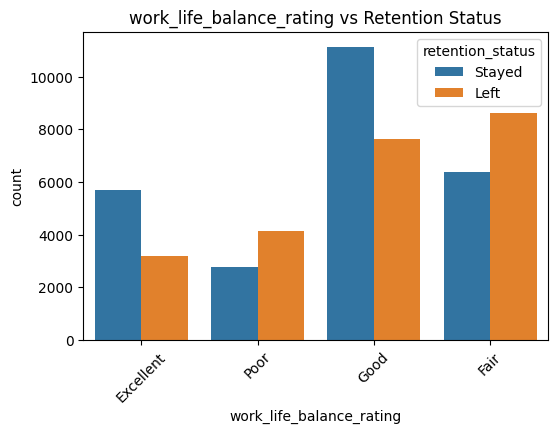

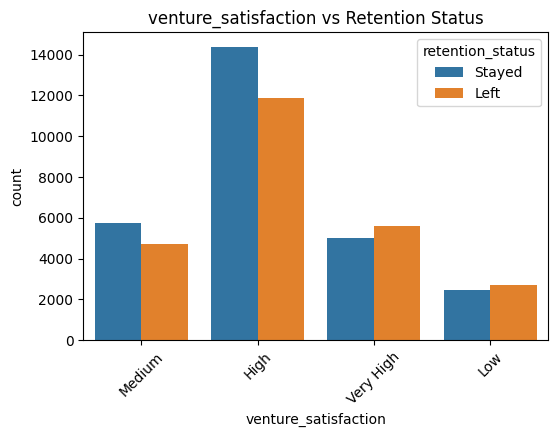

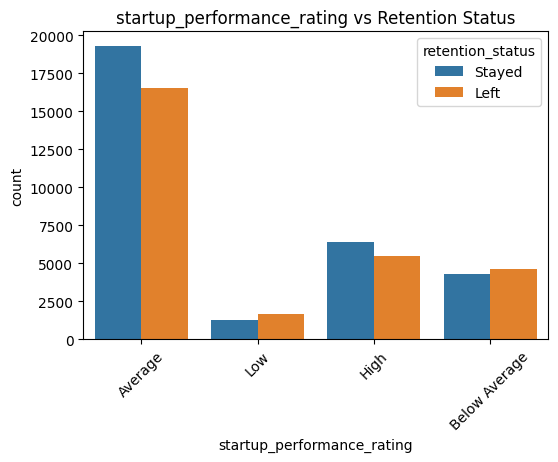

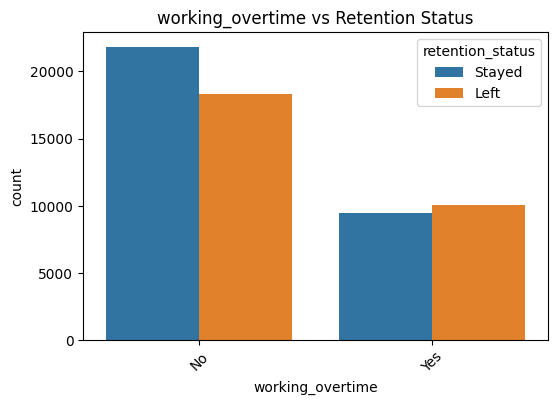

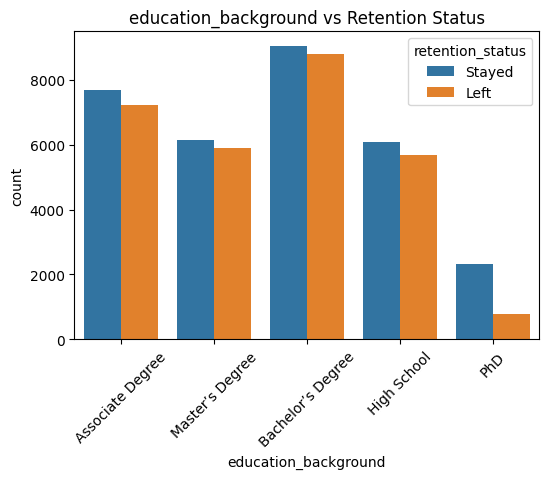

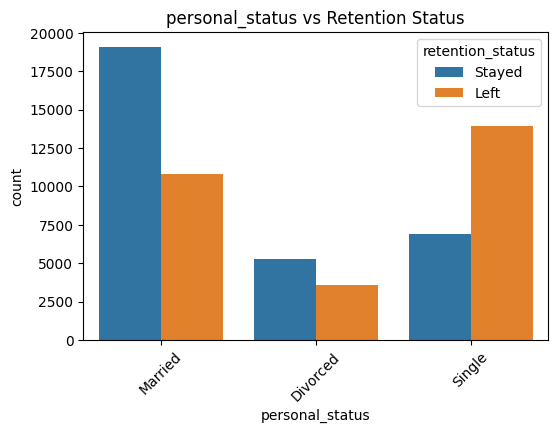

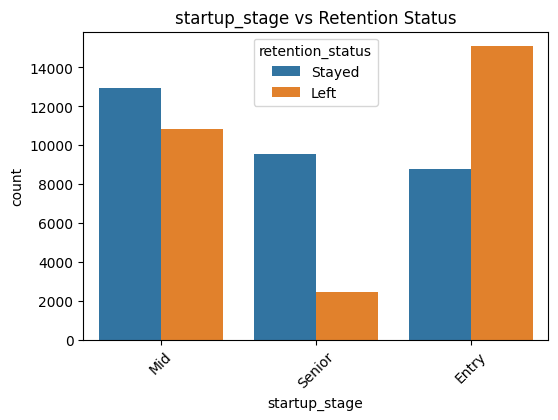

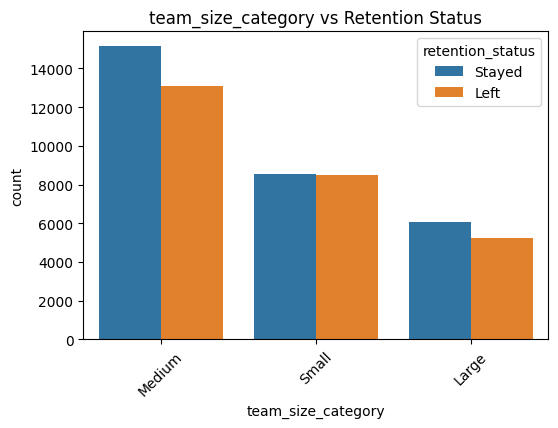

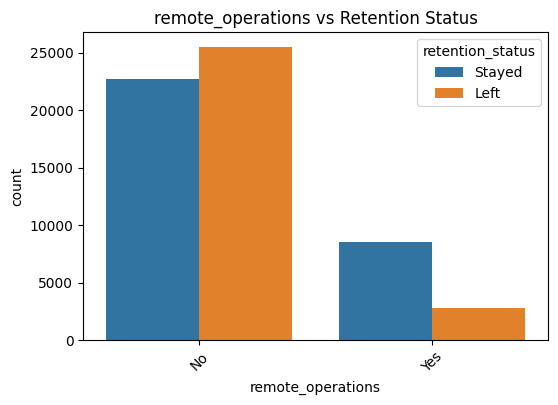

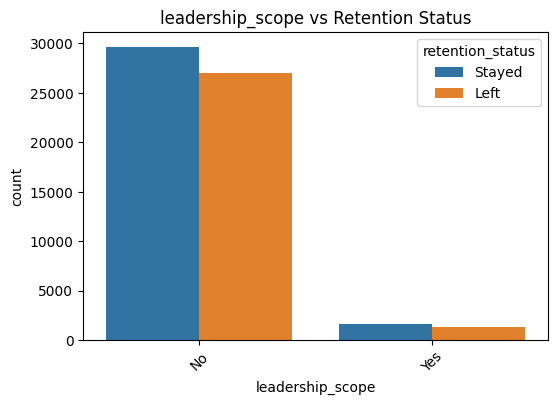

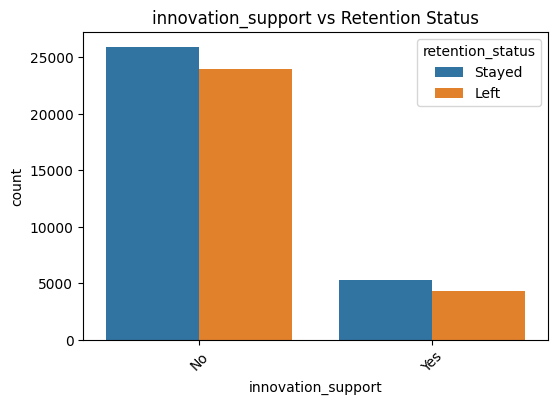

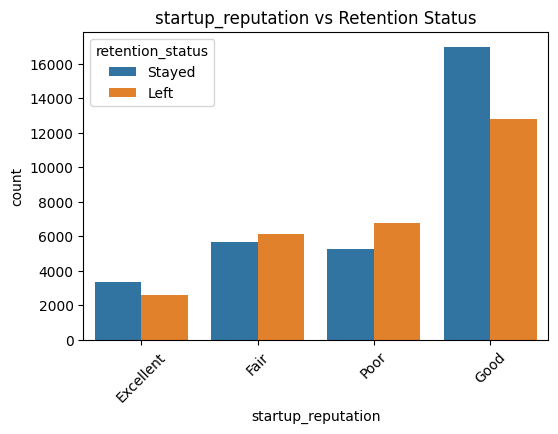

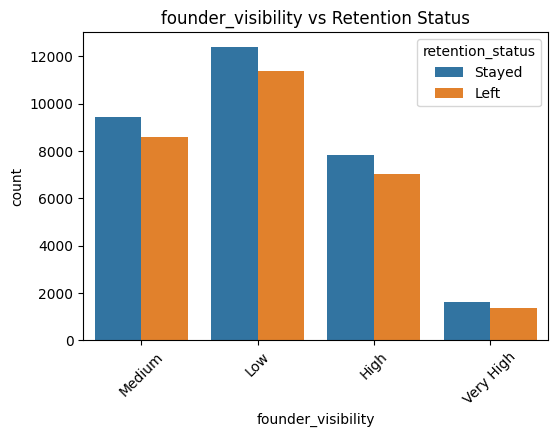

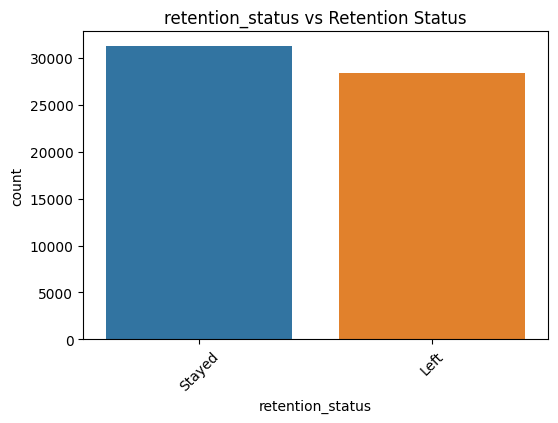

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train, x=col, hue='retention_status')
    plt.title(f"{col} vs Retention Status")
    plt.xticks(rotation=45)
    plt.show()


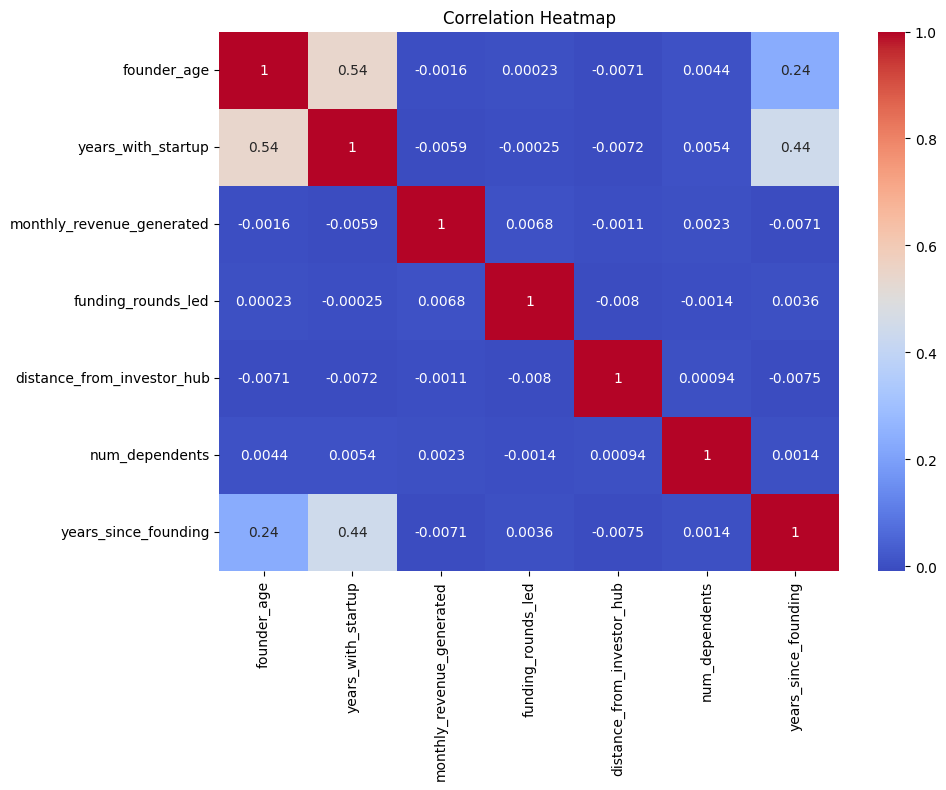

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


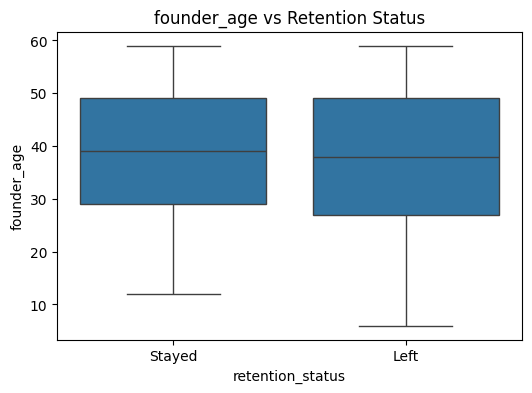

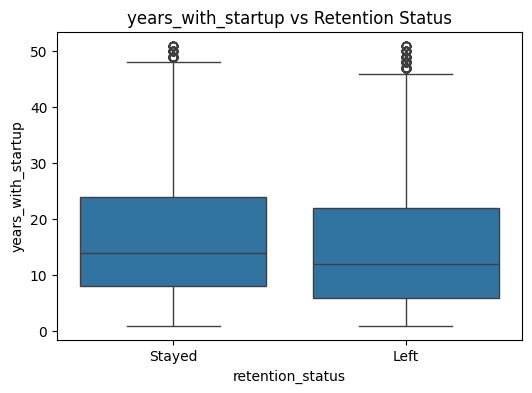

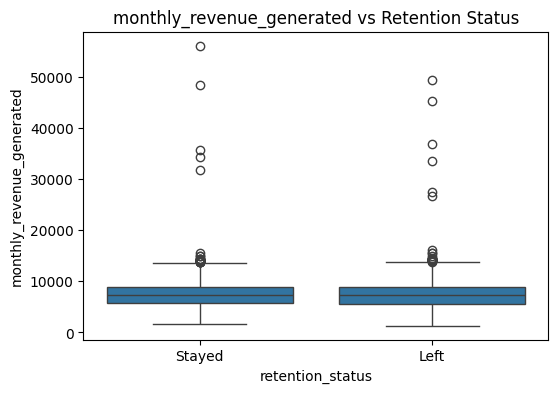

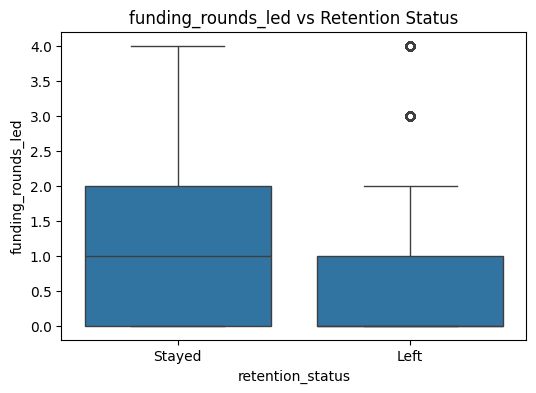

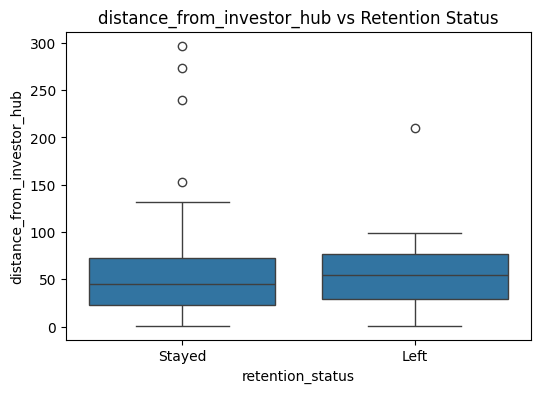

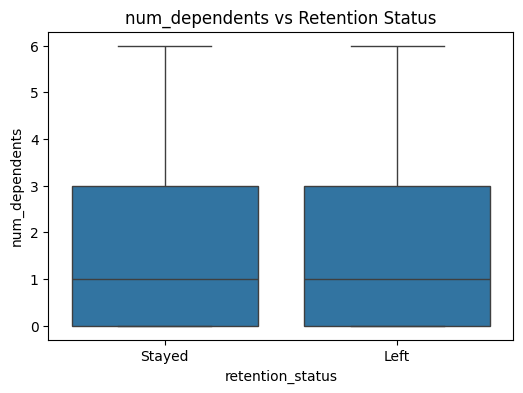

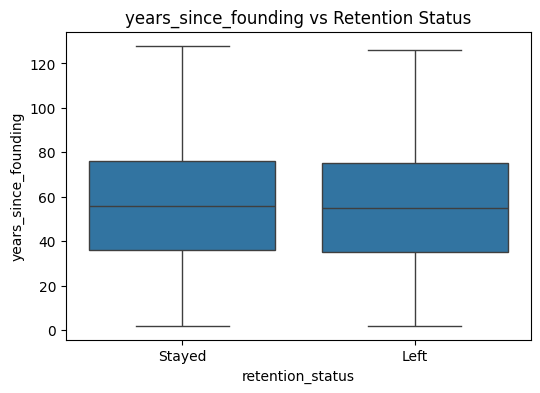

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=train, x='retention_status', y=col)
    plt.title(f"{col} vs Retention Status")
    plt.show()


In [ ]:
X = train.drop(columns=["retention_status"], errors="ignore").drop(columns=["founder_id"], errors="ignore")
y_raw = train["retention_status"].copy()
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_raw)
joblib.dump(le_target, "/final/label_encoder_target.joblib")
print("Saved label encoder to /final/label_encoder_target.joblib")
print("Classes:", list(le_target.classes_))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "y_train:", y_train.shape, "y_val:", y_val.shape)

In [ ]:

pipe_te_df = Pipeline([

    ("targ_enc", ce.TargetEncoder(cols=categorical_cols, smoothing=0.2)),

    ("imputer", SimpleImputer(strategy="median")),

    ("scaler", StandardScaler()),

    ("clf", SVC(kernel="rbf", probability=False, random_state=42))
])
pipe_te_df

In [ ]:
SAMPLE_FRAC = 1.0   # set 1.0 to use full train
if SAMPLE_FRAC < 1.0:
    X_train_sample = X_train.sample(frac=SAMPLE_FRAC, random_state=42)
    y_train_sample = y_train[X_train_sample.index]
    print("Using sampled training set:", X_train_sample.shape)
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print("Using full training set:", X_train_sample.shape)

In [ ]:
best_mlp_pipe = rnd_mlp.best_estimator_
print("Using best MLP params:", rnd_mlp.best_params_)

# 2) Create train/validation split (for threshold search)
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)
print("Train/val split:", X_train_mlp.shape, X_val_mlp.shape)

# 3) Fit on TRAIN only
print("\n🚀 Fitting best MLP on train split...")
best_mlp_pipe.fit(X_train_mlp, y_train_mlp)

# 4) Get validation probabilities
val_probs = best_mlp_pipe.predict_proba(X_val_mlp)[:, 1]

In [ ]:
thresholds = np.linspace(0.3, 0.7, 41)
best_t = 0.5
best_acc = 0

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    acc = accuracy_score(y_val_mlp, preds)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print("\n✅ Best threshold:", best_t)
print("✅ Best validation accuracy:", round(best_acc, 5))

# keep for next cell
tuned_threshold = best_t
best_mlp_pipe_tuned = best_mlp_pipe

In [ ]:
best_mlp_pipe = best_mlp_pipe_tuned
best_t = tuned_threshold
print("Using tuned threshold:", best_t)

# 2) Fit on FULL training data
print("\n🚀 Refitting best MLP on FULL data...")
best_mlp_pipe.fit(X, y_encoded)
print("✅ Full-data fit complete.")

# 3) Predict on test
test_features = test.drop(columns=["founder_id"], errors="ignore")
test_probs = best_mlp_pipe.predict_proba(test_features)[:, 1]
preds_num = (test_probs >= best_t).astype(int)

# 4) Convert back to original labels
preds_str = le_target.inverse_transform(preds_num)
if "founder_id" in test.columns:
    ids = test["founder_id"].values
else:
    ids = np.arange(len(preds_str))

submission = pd.DataFrame({
    "founder_id": ids,
    "retention_status": preds_str
})

out = "/content/submission_mlp_threshold_tuned.csv"
submission.to_csv(out, index=False)

joblib.dump(best_mlp_pipe, "/content/best_mlp_threshold_tuned.joblib")

print("\n✅ Submission saved:", out)
print("✅ Model saved:", "/content/best_mlp_threshold_tuned.joblib")
print("✅ Rows:", len(submission))
print("✅ Used threshold:", best_t)


In [ ]:
best_svm_pipe = rnd_svm.best_estimator_
print("Using best SVM params:", rnd_svm.best_params_)

# 2) Fit on FULL training data
print("\n🚀 Fitting best SVM on FULL training data...")
best_svm_pipe.fit(X, y_encoded)
print("✅ Full-data SVM fit complete.")

# 3) Prepare test features
test_features = test.drop(columns=["founder_id"], errors="ignore")

# 4) Predict encoded labels
svm_preds_num = best_svm_pipe.predict(test_features)

# 5) Convert back to original string labels
svm_preds_str = le_target.inverse_transform(svm_preds_num)

# 6) Build submission
if "founder_id" in test.columns:

    ids = test["founder_id"].values
else:
    ids = np.arange(len(svm_preds_str))

submission_svm_tuned = pd.DataFrame({
    "founder_id": ids,
    "retention_status": svm_preds_str
})

out_svm = "/content/submission_svm_tuned.csv"
submission_svm_tuned.to_csv(out_svm, index=False)

joblib.dump(best_svm_pipe, "/content/svm_tuned_full.joblib")

print("\n✅ Tuned SVM submission saved:", out_svm)
print("✅ Tuned SVM model saved:", "/content/svm_tuned_full.joblib")
print("✅ Submission rows:", len(submission_svm_tuned))


In [ ]:
pipe_lr_df = Pipeline([
    ("targ_enc", ce.TargetEncoder(cols=categorical_cols, smoothing=0.2)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42, solver='liblinear'))
])

print("🚀 Fitting Logistic Regression on FULL training data...")
pipe_lr_df.fit(X, y_encoded)
print("✅ Full-data Logistic Regression fit complete.")

# Prepare test features
test_features = test.drop(columns=["founder_id"], errors="ignore")

# Predict encoded labels
lr_preds_num = pipe_lr_df.predict(test_features)

# Convert back to original string labels
lr_preds_str = le_target.inverse_transform(lr_preds_num)

# Build submission
if "founder_id" in test.columns:
    ids = test["founder_id"].values
else:
    ids = np.arange(len(lr_preds_str))

submission_lr = pd.DataFrame({
    "founder_id": ids,
    "retention_status": lr_preds_str
})

out_lr = "/content/submission_logistic_regression.csv"
submission_lr.to_csv(out_lr, index=False)

joblib.dump(pipe_lr_df, "/content/logistic_regression_full.joblib")

print("\n✅ Logistic Regression submission saved:", out_lr)
print("✅ Logistic Regression model saved:", "/content/logistic_regression_full.joblib")
print("✅ Submission rows:", len(submission_lr))